In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


### Imports

In [ ]:
import os
from tqdm import tqdm
import time
import copy
import gc

import torchvision
from torchvision import datasets, models, transforms

from PIL import Image

import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np


import matplotlib.pyplot as plt

cudnn.benchmark = True

### Versão normal

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Carrega as imagens pré-processadas de cada dataset
base_dir = '/content/gdrive/Shareddrives/TCC - S09/Notebooks/resized data/'

with open(base_dir + 'YS_2017_2017-05-13_05-00-00_10Hz_2058_600.pkl', 'rb') as f:
    YS_2017 = pickle.load(f)

with open(base_dir + 'BS_2011_2011-10-04_11-38-00_12Hz_2058_600.pkl', 'rb') as f:
    BS_2011_1 = pickle.load(f)

# with open(base_dir + 'LJ_2018_2018-01-03_09-39-38_10Hz_2058_600.pkl', 'rb') as f:
#     LJ_2018 = pickle.load(f)

# YS_2017 = torch.load('YS_2017_2017-05-13_05-00-00_10Hz_2058_600.pt')
# AA_2015 = torch.load('AA_2015_2015-03-05_10-35-00_12Hz_preproc_2058_600.pt')
# BS_2011_1 = torch.load('BS_2011_2011-10-04_11-38-00_12Hz_2058_600.pt')
# BS_2011_2 = torch.load('BS_2011_2011-10-01_16-18-00_15Hz_preproc_2058_600.pt')

# Concatena todos os sets em um e atribui os labels às imagens
# em uma tupla: (<tensor>, <classe>)
data = [(x, 0) for x in BS_2011_1]
data += [(x, 1) for x in YS_2017]
# data += [(x, 2) for x in LJ_2018]

del BS_2011_1
del YS_2017
# del LJ_2018

In [ ]:
# Normalização e conversão em tensores
transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  # Transform to tensor
        transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])

data = [(transform(img), label) for img, label in data]

# Split data into training/test set (80/20)
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_set, test_set = torch.utils.data.random_split(data, [train_size, test_size])

image_datasets = {'train': train_set, 'val': test_set}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = [1, 2]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
device

device(type='cuda', index=0)

In [ ]:
# Carrega o modelo
resnet152 = models.resnet152(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
# Congela os parâmetros do feature extraction
for param in resnet152.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = resnet152.fc.in_features
resnet152.fc = nn.Linear(num_ftrs, 2)

resnet152 = resnet152.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(resnet152.fc.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(resnet152, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


100%|██████████| 360/360 [01:37<00:00,  3.69it/s]


train Loss: 0.8755 Acc: 0.8992


100%|██████████| 90/90 [00:22<00:00,  4.09it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 1/9
----------


100%|██████████| 360/360 [01:31<00:00,  3.93it/s]


train Loss: 0.8588 Acc: 0.9242


100%|██████████| 90/90 [00:23<00:00,  3.89it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 2/9
----------


100%|██████████| 360/360 [01:34<00:00,  3.79it/s]


train Loss: 1.8195 Acc: 0.9179


100%|██████████| 90/90 [00:23<00:00,  3.84it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 3/9
----------


100%|██████████| 360/360 [01:35<00:00,  3.78it/s]


train Loss: 0.7712 Acc: 0.9548


100%|██████████| 90/90 [00:23<00:00,  3.83it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 4/9
----------


100%|██████████| 360/360 [01:34<00:00,  3.80it/s]


train Loss: 0.5035 Acc: 0.9659


100%|██████████| 90/90 [00:23<00:00,  3.84it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 5/9
----------


100%|██████████| 360/360 [01:34<00:00,  3.80it/s]


train Loss: 1.1767 Acc: 0.9388


100%|██████████| 90/90 [00:23<00:00,  3.81it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 6/9
----------


100%|██████████| 360/360 [01:35<00:00,  3.76it/s]


train Loss: 0.3149 Acc: 0.9708


100%|██████████| 90/90 [00:23<00:00,  3.84it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 7/9
----------


100%|██████████| 360/360 [01:35<00:00,  3.77it/s]


train Loss: 0.1485 Acc: 0.9896


100%|██████████| 90/90 [00:23<00:00,  3.85it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 8/9
----------


100%|██████████| 360/360 [01:35<00:00,  3.78it/s]


train Loss: 0.1672 Acc: 0.9819


100%|██████████| 90/90 [00:23<00:00,  3.76it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 9/9
----------


100%|██████████| 360/360 [01:35<00:00,  3.77it/s]


train Loss: 0.2316 Acc: 0.9791


100%|██████████| 90/90 [00:23<00:00,  3.83it/s]

val Loss: 0.0000 Acc: 1.0000

Training complete in 19m 44s
Best val Acc: 1.000000


In [ ]:
c0 = 0
c1 = 1
for _, label in dataloaders['val']:
  for el in label:
    if el == 0:
      c0 += 1
    else:
      c1 += 1

print('c0', c0)
print('c1', c1)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


c0 240
c1 121


In [ ]:
torch.save(model_conv.state_dict(), '/content/gdrive/Shareddrives/TCC - S09/Notebooks/resnet152_teste.pth')

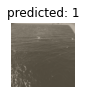

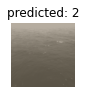

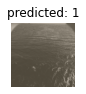

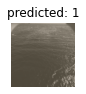

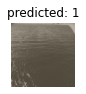

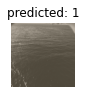

In [ ]:
visualize_model(resnet152)

In [ ]:
def test_all(model):
  model.eval()

  with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            print('labels', labels)
            print('preds', preds)


test_all(model_conv)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


labels tensor([0, 0, 1, 1], device='cuda:0')
preds tensor([0, 0, 1, 1], device='cuda:0')
labels tensor([1, 0, 1, 0], device='cuda:0')
preds tensor([1, 0, 1, 0], device='cuda:0')
labels tensor([0, 0, 1, 0], device='cuda:0')
preds tensor([0, 0, 1, 0], device='cuda:0')
labels tensor([0, 0, 0, 0], device='cuda:0')
preds tensor([0, 0, 0, 0], device='cuda:0')
labels tensor([1, 0, 1, 0], device='cuda:0')
preds tensor([1, 0, 1, 0], device='cuda:0')
labels tensor([0, 0, 1, 0], device='cuda:0')
preds tensor([0, 0, 1, 0], device='cuda:0')
labels tensor([1, 0, 1, 0], device='cuda:0')
preds tensor([1, 0, 1, 0], device='cuda:0')
labels tensor([0, 0, 0, 0], device='cuda:0')
preds tensor([0, 0, 0, 0], device='cuda:0')
labels tensor([0, 0, 0, 0], device='cuda:0')
preds tensor([0, 0, 0, 0], device='cuda:0')
labels tensor([0, 1, 0, 0], device='cuda:0')
preds tensor([0, 1, 0, 0], device='cuda:0')
labels tensor([1, 0, 1, 0], device='cuda:0')
preds tensor([1, 0, 1, 0], device='cuda:0')
labels tensor([0, 0, 

### Versão em batches

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, label: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Carrega as imagens pré-processadas de cada dataset
# with open('/content/gdrive/Shareddrives/TCC - S09/Notebooks/batch data/train_1.pkl', 'rb') as f:
#     train1 = pickle.load(f)

# with open('/content/gdrive/Shareddrives/TCC - S09/Notebooks/batch data/train_2.pkl', 'rb') as f:
#     train1 = pickle.load(f)

with open('/content/gdrive/Shareddrives/TCC - S09/Notebooks/batch data/train_3.pkl', 'rb') as f:
    train1 = pickle.load(f)

with open('/content/gdrive/Shareddrives/TCC - S09/Notebooks/batch data/val.pkl', 'rb') as f:
    val = pickle.load(f)

In [ ]:
# Normalização e conversão em tensores
transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  # Transform to tensor
        transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])

# data = [(transform(img), label) for img, label in data]

train1 = [(transform(img), label) for img, label in train1]
val = [(transform(img), label) for img, label in val]
# val = []

image_datasets = {'train': train1, 'val': val}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
# dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=4,
#                                              shuffle=True, num_workers=4),
#                'val': image_datasets['val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = [1, 2, 3]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
device

device(type='cuda', index=0)

In [ ]:
# Carrega o modelo
resnet152 = models.resnet152(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Congela os parâmetros do feature extraction
# for param in resnet152.parameters():
#     param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = resnet152.fc.in_features
resnet152.fc = nn.Linear(num_ftrs, 3)

resnet152.load_state_dict(torch.load('/content/gdrive/Shareddrives/TCC - S09/Notebooks/resnet152_linear_1_1_1.pth', map_location=lambda storage, loc: storage))
# Congela os parâmetros do feature extraction
for param in resnet152.parameters():
    param.requires_grad = False

for param in resnet152.fc.parameters():
  param.requires_grad = True

resnet152 = resnet152.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(resnet152.fc.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(resnet152, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


100%|██████████| 240/240 [01:05<00:00,  3.65it/s]


train Loss: 0.8298 Acc: 0.9167


100%|██████████| 180/180 [00:43<00:00,  4.14it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 1/9
----------


100%|██████████| 240/240 [00:59<00:00,  4.01it/s]


train Loss: 0.7727 Acc: 0.9187


100%|██████████| 180/180 [00:43<00:00,  4.13it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 2/9
----------


100%|██████████| 240/240 [00:59<00:00,  4.01it/s]


train Loss: 0.5658 Acc: 0.9510


100%|██████████| 180/180 [00:43<00:00,  4.13it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 3/9
----------


100%|██████████| 240/240 [01:00<00:00,  4.00it/s]


train Loss: 0.6546 Acc: 0.9385


100%|██████████| 180/180 [00:43<00:00,  4.13it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 4/9
----------


100%|██████████| 240/240 [00:59<00:00,  4.01it/s]


train Loss: 0.4400 Acc: 0.9500


100%|██████████| 180/180 [00:43<00:00,  4.12it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 5/9
----------


100%|██████████| 240/240 [00:59<00:00,  4.01it/s]


train Loss: 0.8718 Acc: 0.9260


100%|██████████| 180/180 [00:43<00:00,  4.14it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 6/9
----------


100%|██████████| 240/240 [00:59<00:00,  4.01it/s]


train Loss: 0.5040 Acc: 0.9427


100%|██████████| 180/180 [00:43<00:00,  4.12it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 7/9
----------


100%|██████████| 240/240 [00:59<00:00,  4.00it/s]


train Loss: 0.1552 Acc: 0.9823


100%|██████████| 180/180 [00:43<00:00,  4.10it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 8/9
----------


100%|██████████| 240/240 [01:00<00:00,  4.00it/s]


train Loss: 0.2552 Acc: 0.9615


100%|██████████| 180/180 [00:43<00:00,  4.12it/s]


val Loss: 0.0000 Acc: 1.0000

Epoch 9/9
----------


100%|██████████| 240/240 [01:00<00:00,  4.00it/s]


train Loss: 0.1635 Acc: 0.9729


100%|██████████| 180/180 [00:43<00:00,  4.12it/s]

val Loss: 0.0000 Acc: 1.0000

Training complete in 17m 22s
Best val Acc: 1.000000


In [ ]:
torch.save(model_conv.state_dict(), '/content/gdrive/Shareddrives/TCC - S09/Notebooks/resnet152_linear_1_1_1.pth')

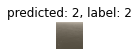

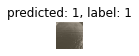

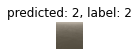

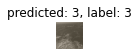

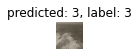

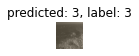

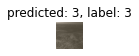

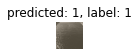

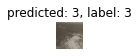

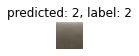

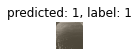

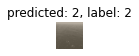

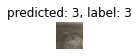

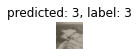

In [ ]:
visualize_model(model_conv, 14)

In [ ]:
# Carrega as imagens pré-processadas de cada dataset
base_dir = '/content/gdrive/Shareddrives/TCC - S09/Notebooks/resized data/'

# with open(base_dir + 'BS_2013_2013-09-25_12-15-01_12Hz_2058_600.pkl', 'rb') as f:
#     data = pickle.load(f)

with open(base_dir + 'BS_2011_2011-10-04_11-38-00_12Hz_2058_600.pkl', 'rb') as f:
    data = pickle.load(f)

# with open(base_dir + 'LJ_2018_2018-01-03_09-39-38_10Hz_2058_600.pkl', 'rb') as f:
#     data = pickle.load(f)

# with open(base_dir + 'AA_2015_2015-03-05_10-35-00_12Hz_2058_600.pkl', 'rb') as f:
#     data = pickle.load(f)

# YS_2017 = torch.load('YS_2017_2017-05-13_05-00-00_10Hz_2058_600.pt')
# AA_2015 = torch.load('AA_2015_2015-03-05_10-35-00_12Hz_preproc_2058_600.pt')
# BS_2011_1 = torch.load('BS_2011_2011-10-04_11-38-00_12Hz_2058_600.pt')
# BS_2011_2 = torch.load('BS_2011_2011-10-01_16-18-00_15Hz_preproc_2058_600.pt')

# Concatena todos os sets em um e atribui os labels às imagens
# em uma tupla: (<tensor>, <classe>)
data = [(x, 0) for x in data]
# data += [(x, 1) for x in YS_2017]
# data += [(x, 2) for x in LJ_2018]


In [ ]:
# Normalização e conversão em tensores
transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  # Transform to tensor
        transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])

data = [(transform(img), label) for img, label in data]

# Split data into training/test set (80/20)
# train_size = int(0.8 * len(data))
# test_size = len(data) - train_size
# train_set, test_set = torch.utils.data.random_split(data, [train_size, test_size])

# image_datasets = {'train': train_set, 'val': test_set}

# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
dataloaders = {'val': torch.utils.data.DataLoader(data, batch_size=4,
                                             shuffle=True, num_workers=4)}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = [1, 2, 3]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
model = models.resnet152(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
model.load_state_dict(torch.load('/content/gdrive/Shareddrives/TCC - S09/Notebooks/resnet152_linear_1_1_1.pth', map_location=lambda storage, loc: storage))
print('Model loaded from %s.' % 'resnet152_linear_1_1_1')
model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded from resnet152_linear_1_1_1.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def test_dataset(model):
  model.eval()
  count = 0

  with torch.no_grad():
      for i, (inputs, labels) in enumerate(dataloaders['val']):
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)

          for j in range(labels.shape[0]):
            if labels[j] == preds[j]:
              count +=1
          

      print(f'Num de acertos/Num de samples:{count}/{len(data)}')
      print('Acurácia:', count/len(data))

test_dataset(model)

Num de acertos/Num de samples:1198/1198
Acurácia: 1.0


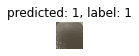

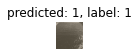

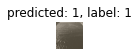

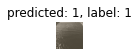

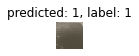

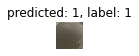

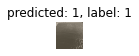

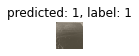

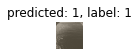

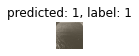

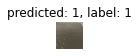

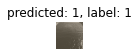

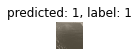

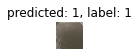

In [ ]:
visualize_model(model, 14)

In [ ]:
for param in model_conv.fc.parameters():
  print(param.requires_grad)

True
True


### Treino em batches automatizado

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),  # Transform to tensor
            transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
    ])
    
    class_names = [1, 2, 3]
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        dataset_sizes = {x: 0 for x in ['train', 'val']}
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                batch_files = [f'train_{x+1}' for x in range(3)]
            else:
                model.eval()   # Set model to evaluate mode
                batch_files = ['val']

            running_loss = 0.0
            running_corrects = 0

            # Set the dataloaders for each batch
            for batch_file in batch_files:
              # Carrega as imagens pré-processadas de cada dataset
              with open(f'/content/gdrive/Shareddrives/TCC - S09/Notebooks/batch data/{batch_file}.pkl', 'rb') as f:
                  data = pickle.load(f)

              # Normalização e conversão em tensores
              data = [(transform(img), label) for img, label in data]

              if phase == 'train':
                image_datasets = {'train': data, 'val': []}
                dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=4,
                                                          shuffle=True, num_workers=4),
                               'val': []}
              else:
                image_datasets = {'train': [], 'val': data}
                dataloaders = {'train': [],
                               'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=4,
                                                          shuffle=True, num_workers=4)}
              

              dataset_sizes = {x: dataset_sizes[x]+len(image_datasets[x]) for x in ['train', 'val']}

              # Iterate over data.
              for inputs, labels in tqdm(dataloaders[phase]):
                  inputs = inputs.to(device)
                  labels = labels.to(device)

                  # zero the parameter gradients
                  optimizer.zero_grad()

                  # forward
                  # track history if only in train
                  with torch.set_grad_enabled(phase == 'train'):
                      outputs = model(inputs)
                      _, preds = torch.max(outputs, 1)
                      loss = criterion(outputs, labels)

                      # backward + optimize only if in training phase
                      if phase == 'train':
                          loss.backward()
                          optimizer.step()

                  # statistics
                  running_loss += loss.item() * inputs.size(0)
                  running_corrects += torch.sum(preds == labels.data)
              if phase == 'train':
                  scheduler.step()

              epoch_loss = running_loss / dataset_sizes[phase]
              epoch_acc = running_corrects.double() / dataset_sizes[phase]

              print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ({running_corrects.double()}/{dataset_sizes[phase]}) \n')

              # deep copy the model
              if phase == 'val' and epoch_acc >= best_acc:
                  best_acc = epoch_acc
                  best_model_wts = copy.deepcopy(model.state_dict())
              
              # Delete current partial dataset
              del data
              del image_datasets
              del dataloaders
              gc.collect()

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Carrega o modelo
resnet152 = models.resnet152(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Congela os parâmetros do feature extraction
for param in resnet152.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = resnet152.fc.in_features
resnet152.fc = nn.Linear(num_ftrs, 3)

resnet152 = resnet152.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(resnet152.fc.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(resnet152, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 240/240 [01:09<00:00,  3.45it/s]


train Loss: 0.9109 Acc: 0.8415 (807.0/959) 



100%|██████████| 240/240 [00:56<00:00,  4.28it/s]


train Loss: 1.1071 Acc: 0.8551 (1640.0/1918) 



100%|██████████| 240/240 [00:57<00:00,  4.15it/s]


train Loss: 1.0304 Acc: 0.8780 (2527.0/2878) 



100%|██████████| 180/180 [00:41<00:00,  4.29it/s]


val Loss: 0.0000 Acc: 1.0000 (720.0/720) 


Epoch 1/9
----------


100%|██████████| 240/240 [00:58<00:00,  4.12it/s]


train Loss: 1.2183 Acc: 0.8822 (846.0/959) 



100%|██████████| 240/240 [00:58<00:00,  4.09it/s]


train Loss: 1.6611 Acc: 0.8723 (1673.0/1918) 



100%|██████████| 240/240 [00:59<00:00,  4.07it/s]


train Loss: 1.4150 Acc: 0.8892 (2559.0/2878) 



100%|██████████| 180/180 [00:42<00:00,  4.20it/s]


val Loss: 0.0000 Acc: 1.0000 (720.0/720) 


Epoch 2/9
----------


100%|██████████| 240/240 [00:58<00:00,  4.07it/s]


train Loss: 0.5223 Acc: 0.9583 (919.0/959) 



100%|██████████| 240/240 [00:59<00:00,  4.06it/s]


train Loss: 0.3606 Acc: 0.9651 (1851.0/1918) 



100%|██████████| 240/240 [00:59<00:00,  4.06it/s]


train Loss: 0.3098 Acc: 0.9687 (2788.0/2878) 



100%|██████████| 180/180 [00:42<00:00,  4.20it/s]


val Loss: 0.0000 Acc: 1.0000 (720.0/720) 


Epoch 3/9
----------


100%|██████████| 240/240 [00:59<00:00,  4.06it/s]


train Loss: 0.3309 Acc: 0.9656 (926.0/959) 



100%|██████████| 240/240 [00:58<00:00,  4.07it/s]


train Loss: 0.3146 Acc: 0.9677 (1856.0/1918) 



100%|██████████| 240/240 [00:59<00:00,  4.06it/s]


train Loss: 0.2461 Acc: 0.9722 (2798.0/2878) 



100%|██████████| 180/180 [00:42<00:00,  4.22it/s]


val Loss: 0.0000 Acc: 1.0000 (720.0/720) 


Epoch 4/9
----------


100%|██████████| 240/240 [00:59<00:00,  4.06it/s]


train Loss: 0.3793 Acc: 0.9531 (914.0/959) 



100%|██████████| 240/240 [00:59<00:00,  4.07it/s]


train Loss: 0.2726 Acc: 0.9672 (1855.0/1918) 



100%|██████████| 240/240 [00:58<00:00,  4.07it/s]


train Loss: 0.2116 Acc: 0.9732 (2801.0/2878) 



100%|██████████| 180/180 [00:42<00:00,  4.21it/s]


val Loss: 0.0000 Acc: 1.0000 (720.0/720) 


Epoch 5/9
----------


100%|██████████| 240/240 [00:59<00:00,  4.06it/s]


train Loss: 0.2570 Acc: 0.9729 (933.0/959) 



100%|██████████| 240/240 [00:58<00:00,  4.08it/s]


train Loss: 0.2340 Acc: 0.9729 (1866.0/1918) 



100%|██████████| 240/240 [00:59<00:00,  4.06it/s]


train Loss: 0.2179 Acc: 0.9732 (2801.0/2878) 



100%|██████████| 180/180 [00:42<00:00,  4.22it/s]


val Loss: 0.0000 Acc: 1.0000 (720.0/720) 


Epoch 6/9
----------


100%|██████████| 240/240 [00:59<00:00,  4.05it/s]


train Loss: 0.1847 Acc: 0.9760 (936.0/959) 



100%|██████████| 240/240 [00:59<00:00,  4.07it/s]


train Loss: 0.2892 Acc: 0.9640 (1849.0/1918) 



100%|██████████| 240/240 [00:59<00:00,  4.06it/s]


train Loss: 0.2638 Acc: 0.9663 (2781.0/2878) 



100%|██████████| 180/180 [00:42<00:00,  4.20it/s]


val Loss: 0.0000 Acc: 1.0000 (720.0/720) 


Epoch 7/9
----------


100%|██████████| 240/240 [00:59<00:00,  4.05it/s]


train Loss: 0.2589 Acc: 0.9614 (922.0/959) 



100%|██████████| 240/240 [00:59<00:00,  4.06it/s]


train Loss: 0.3177 Acc: 0.9588 (1839.0/1918) 



100%|██████████| 240/240 [00:58<00:00,  4.07it/s]


train Loss: 0.3033 Acc: 0.9604 (2764.0/2878) 



100%|██████████| 180/180 [00:42<00:00,  4.19it/s]


val Loss: 0.0000 Acc: 1.0000 (720.0/720) 


Epoch 8/9
----------


100%|██████████| 240/240 [00:59<00:00,  4.05it/s]


train Loss: 0.2149 Acc: 0.9645 (925.0/959) 



100%|██████████| 240/240 [00:58<00:00,  4.07it/s]


train Loss: 0.2439 Acc: 0.9645 (1850.0/1918) 



100%|██████████| 240/240 [00:59<00:00,  4.05it/s]


train Loss: 0.1843 Acc: 0.9732 (2801.0/2878) 



100%|██████████| 180/180 [00:42<00:00,  4.19it/s]


val Loss: 0.0000 Acc: 1.0000 (720.0/720) 


Epoch 9/9
----------


100%|██████████| 240/240 [00:59<00:00,  4.06it/s]


train Loss: 0.4169 Acc: 0.9645 (925.0/959) 



100%|██████████| 240/240 [00:58<00:00,  4.07it/s]


train Loss: 0.3379 Acc: 0.9713 (1863.0/1918) 



100%|██████████| 240/240 [00:59<00:00,  4.07it/s]


train Loss: 0.3017 Acc: 0.9691 (2789.0/2878) 



100%|██████████| 180/180 [00:43<00:00,  4.19it/s]


val Loss: 0.0000 Acc: 1.0000 (720.0/720) 


Training complete in 50m 38s
Best val Acc: 1.000000


In [ ]:
torch.save(model_conv.state_dict(), '/content/gdrive/Shareddrives/TCC - S09/Notebooks/resnet152_linear_1_1_1_auto.pth')

In [ ]:
# Carrega as imagens pré-processadas de cada dataset
base_dir = '/content/gdrive/Shareddrives/TCC - S09/Notebooks/resized data/'

# with open(base_dir + 'BS_2013_2013-09-25_12-15-01_12Hz_2058_600.pkl', 'rb') as f:
#     data = pickle.load(f)

# with open(base_dir + 'BS_2011_2011-10-04_11-38-00_12Hz_2058_600.pkl', 'rb') as f:
#     data = pickle.load(f)

# with open(base_dir + 'LJ_2018_2018-01-03_09-39-38_10Hz_2058_600.pkl', 'rb') as f:
#     data = pickle.load(f)

with open(base_dir + 'AA_2015_2015-03-05_10-35-00_12Hz_2058_600.pkl', 'rb') as f:
    data = pickle.load(f)

# YS_2017 = torch.load('YS_2017_2017-05-13_05-00-00_10Hz_2058_600.pt')
# AA_2015 = torch.load('AA_2015_2015-03-05_10-35-00_12Hz_preproc_2058_600.pt')
# BS_2011_1 = torch.load('BS_2011_2011-10-04_11-38-00_12Hz_2058_600.pt')
# BS_2011_2 = torch.load('BS_2011_2011-10-01_16-18-00_15Hz_preproc_2058_600.pt')

# Concatena todos os sets em um e atribui os labels às imagens
# em uma tupla: (<tensor>, <classe>)
data = [(x, 1) for x in data]
# data += [(x, 1) for x in YS_2017]
# data += [(x, 2) for x in LJ_2018]

In [ ]:
# Normalização e conversão em tensores
transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  # Transform to tensor
        transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])

data = [(transform(img), label) for img, label in data]

# Split data into training/test set (80/20)
# train_size = int(0.8 * len(data))
# test_size = len(data) - train_size
# train_set, test_set = torch.utils.data.random_split(data, [train_size, test_size])

# image_datasets = {'train': train_set, 'val': test_set}

# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
dataloaders = {'val': torch.utils.data.DataLoader(data, batch_size=4,
                                             shuffle=True, num_workers=4)}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = [1, 2, 3]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
model = models.resnet152(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
model.load_state_dict(torch.load('/content/gdrive/Shareddrives/TCC - S09/Notebooks/resnet152_linear_1_1_1_auto.pth', map_location=lambda storage, loc: storage))
print('Model loaded from %s.' % 'resnet152_linear_1_1_1')
model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded from resnet152_linear_1_1_1.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def test_dataset(model):
  model.eval()
  count = 0

  with torch.no_grad():
      for i, (inputs, labels) in enumerate(dataloaders['val']):
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)

          for j in range(labels.shape[0]):
            if labels[j] == preds[j]:
              count +=1
          

      print(f'Num de acertos/Num de samples:{count}/{len(data)}')
      print('Acurácia:', count/len(data))

test_dataset(model)

Num de acertos/Num de samples:1310/1798
Acurácia: 0.728587319243604
